## Import libraries

In [70]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import joblib
import seaborn as sns  
from sklearn.metrics import mean_squared_error
from lime.lime_tabular import LimeTabularExplainer  

## Display results Latex table

In [71]:
results = pd.read_csv('results.csv')

In [74]:
results

,Approach,Prediction Horizon,Patient,RMSE
0,gpt4o,6,1,16.279481
1,gpt4o,6,2,21.769417
2,gpt4o,6,4,24.880923
3,gpt4o,6,6,15.973342
4,gpt4o,6,7,17.788671
...,...,...,...,...
67,nollm,12,2,44.026541
68,nollm,12,4,50.481048
69,nollm,12,6,30.447818
70,nollm,12,7,32.713113


In [32]:
agg_results = results.groupby(['Approach', 'Prediction Horizon'])['RMSE'].agg(['mean', 'std']).reset_index()  
agg_results.columns = ['Approach', 'Prediction Horizon', 'Average RMSE', 'Std RMSE']  

In [72]:
def create_latex_table(df):
    df['RMSE'] = df.apply(lambda row: f"{row['Average RMSE']:.2f} ± {row['Std RMSE']:.2f}", axis=1)
    table = df.pivot(index='Approach', columns='Prediction Horizon', values='RMSE')
    
    latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|c|}\n\\hline\n"
    latex_table += "Approach & 30 Minutes & 45 Minutes & 60 Minutes \\\\\n\\hline\n"
    
    for idx, row in table.iterrows():
        latex_table += f"{idx} & {' & '.join(row.values)} \\\\\n\\hline\n"
    
    latex_table += "\\end{tabular}\n\\caption{RMSE Results}\n\\end{table}"
    return latex_table

In [73]:
latex_table = create_latex_table(agg_results) 
print(latex_table)

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Approach & 30 Minutes & 45 Minutes & 60 Minutes \\
\hline
gpt4o & 19.37 ± 3.46 & 29.39 ± 5.90 & 36.88 ± 8.99 \\
\hline
llava & 19.92 ± 3.56 & 29.84 ± 5.68 & 36.88 ± 8.55 \\
\hline
nollm & 20.01 ± 3.78 & 30.19 ± 6.20 & 38.33 ± 7.53 \\
\hline
sonnet & 19.63 ± 3.48 & 29.61 ± 5.90 & 37.02 ± 9.23 \\
\hline
\end{tabular}
\caption{RMSE Results}
\end{table}


In [35]:
df_pivot = results.pivot_table(index=['Approach', 'Patient'], columns='Prediction Horizon', values='RMSE')

# Round to two decimal places and format to avoid trailing zeros
df_pivot = df_pivot.map(lambda x: f"{x:.2f}" if pd.notnull(x) else "")

# Reset index to get the DataFrame in a tabular format
df_pivot.reset_index(inplace=True)

# Convert to LaTeX
latex_table = df_pivot.to_latex(index=False, escape=False)

print(latex_table)

\begin{tabular}{lrlll}
\toprule
Approach & Patient & 6 & 9 & 12 \\
\midrule
gpt4o & 1 & 16.28 & 25.33 & 30.81 \\
gpt4o & 2 & 21.77 & 34.75 & 45.88 \\
gpt4o & 4 & 24.88 & 38.43 & 49.80 \\
gpt4o & 6 & 15.97 & 24.19 & 31.06 \\
gpt4o & 7 & 17.79 & 25.00 & 27.70 \\
gpt4o & 8 & 19.51 & 28.62 & 36.03 \\
llava & 1 & 16.90 & 25.62 & 31.96 \\
llava & 2 & 21.76 & 33.84 & 44.46 \\
llava & 4 & 25.96 & 39.13 & 49.48 \\
llava & 6 & 16.20 & 23.98 & 30.34 \\
llava & 7 & 19.39 & 27.34 & 27.83 \\
llava & 8 & 19.31 & 29.13 & 37.23 \\
nollm & 1 & 17.38 & 27.77 & 35.89 \\
nollm & 2 & 21.41 & 33.80 & 44.03 \\
nollm & 4 & 26.63 & 40.80 & 50.48 \\
nollm & 6 & 15.83 & 23.22 & 30.45 \\
nollm & 7 & 19.99 & 27.43 & 32.71 \\
nollm & 8 & 18.82 & 28.10 & 36.44 \\
sonnet & 1 & 16.52 & 25.55 & 31.29 \\
sonnet & 2 & 21.79 & 34.79 & 45.15 \\
sonnet & 4 & 25.33 & 38.79 & 51.19 \\
sonnet & 6 & 16.00 & 23.90 & 30.41 \\
sonnet & 7 & 18.94 & 26.04 & 27.99 \\
sonnet & 8 & 19.18 & 28.58 & 36.06 \\
\bottomrule
\end{tabular}



## Investigate performance differences between patients

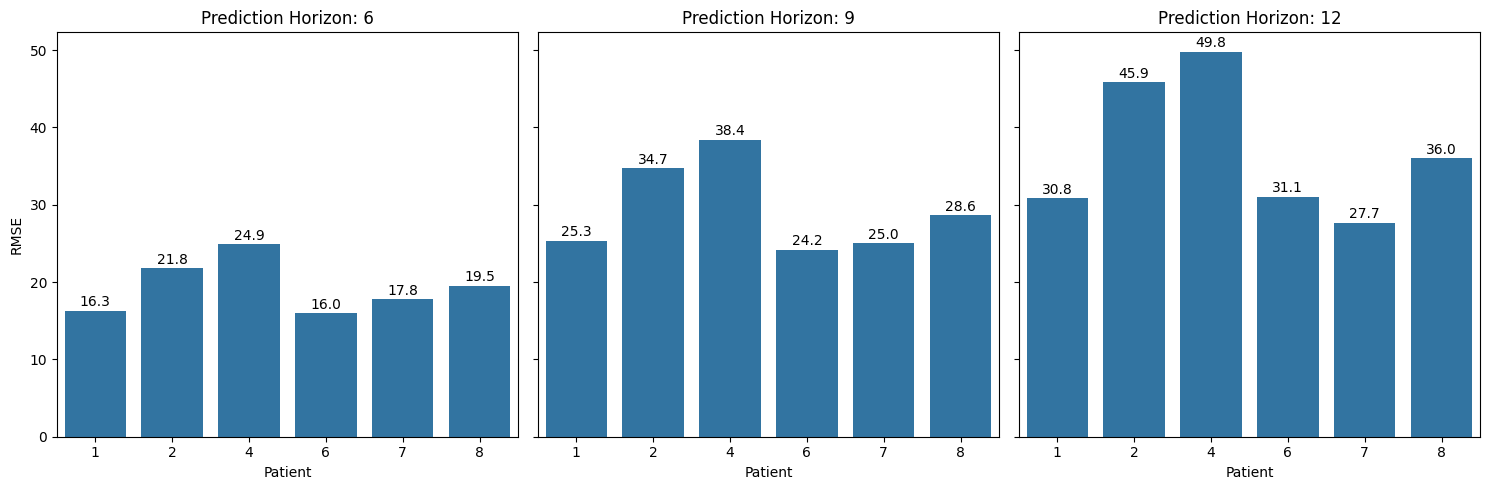

In [38]:
selected_results = results[results['Approach'].isin(['gpt4o'])]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Define prediction horizons
prediction_horizons = [6, 9, 12]

# Plot each prediction horizon
for i, horizon in enumerate(prediction_horizons):
    ax = axes[i]
    # Create the bar plot and store the returned object
    bars = sns.barplot(x='Patient', y='RMSE', hue='Approach', data=selected_results[selected_results['Prediction Horizon'] == horizon], ax=ax)
    
    # Add value labels on top of each bar with smaller font size
    for container in bars.containers:
        bars.bar_label(container, fmt='%.1f', padding=1, fontsize=10)
    
    ax.set_title(f'Prediction Horizon: {horizon}')
    ax.set_xlabel('Patient')
    ax.set_ylabel('RMSE' if i == 0 else '')
    ax.get_legend().remove()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [42]:
def find_patients_with_lowest_rmse(df, ph):
    df = df[df['Prediction Horizon']==ph]
    pivot_df = df.pivot(index='Patient', columns='Approach', values='RMSE')
    
    # Find patients where "nollm" has the lowest RMSE
    patients_with_lowest_rmse = pivot_df.idxmin(axis=1)
    return patients_with_lowest_rmse[patients_with_lowest_rmse == 'nollm'].index.tolist()

for ph in [6, 9, 12]:
    patients_with_lowest_rmse = find_patients_with_lowest_rmse(results, ph)
    print(f"Patients where 'nollm' has the lowest RMSE at PH {ph}:", patients_with_lowest_rmse)

Patients where 'nollm' has the lowest RMSE at PH 6: [2, 6, 8]
Patients where 'nollm' has the lowest RMSE at PH 9: [2, 6, 8]
Patients where 'nollm' has the lowest RMSE at PH 12: [2]


## Investigate whether glucose and food data differ between patients

In [43]:
def plot_timeline_with_predictions(ground_truth, datetime, y_preds, approaches):  

    # Combining dataframes
    data_ground_truth = pd.DataFrame({  
        'Datetime': datetime,  
        'Glucose Level': ground_truth,  
        'Type': 'Ground Truth'  
    })  
    all_data_predictions = []  
    for approach in approaches:  
        data_predictions = pd.DataFrame({  
            'Datetime': datetime,  
            'Glucose Level': y_preds[approach],  
            'Type': f'Prediction {approach}'  
        })  
        all_data_predictions.append(data_predictions)  
    data_combined = pd.concat([data_ground_truth] + all_data_predictions, ignore_index=True)  
    data_combined['Datetime'] = pd.to_datetime(data_combined['Datetime'])  
    data_combined['Time'] = data_combined['Datetime'].dt.strftime('%H:%M')  
      
    # Plotting  
    sns.set_theme(style="whitegrid")  
    plt.figure(figsize=(12, 6))  
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'],  
                 x='Time',  
                 y='Glucose Level',  
                 label='Ground Truth',  
                 color='#1f77b4',  
                 alpha=1.0)  
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    for i, approach in enumerate(approaches):  
        sns.lineplot(data=data_combined[data_combined['Type'] == f'Prediction {approach}'],  
                     x='Time',  
                     y='Glucose Level',  
                     label=f'Prediction {approach}',  
                     color=colors[i],  
                     alpha=0.7)  
      
    plt.xlabel("Time", fontsize=12)  
    plt.ylabel("Glucose Level (mg/dL)", fontsize=12)  
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.legend(fontsize=10)  
      
    # Adjusting x-axis tick frequency  
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
      
    plt.tight_layout()  
    plt.show()  

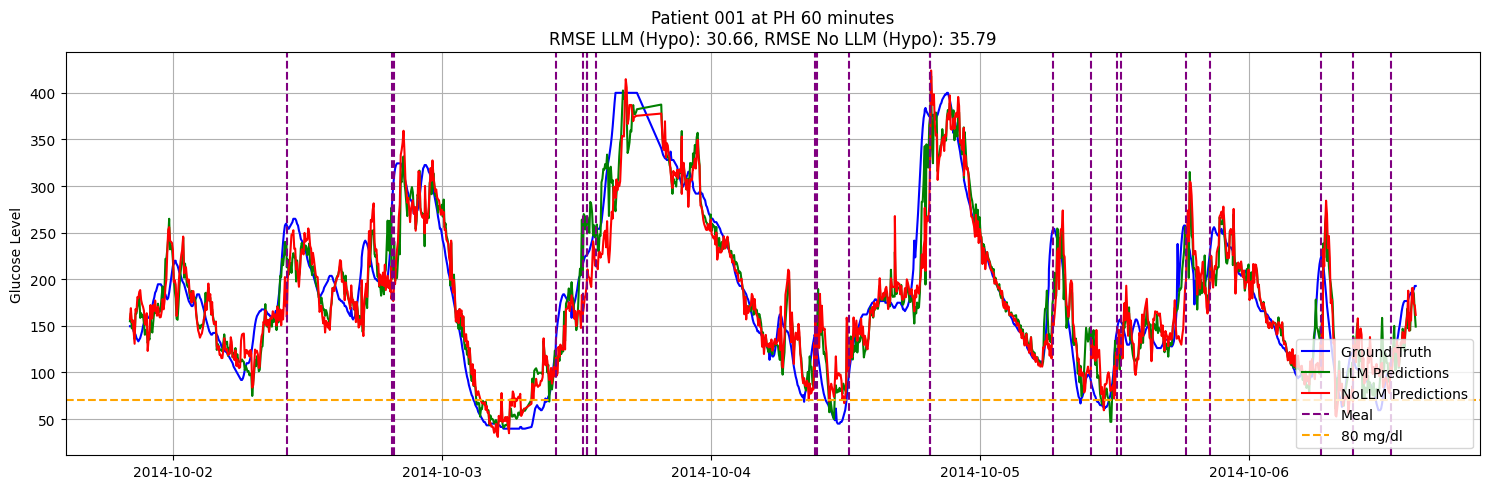

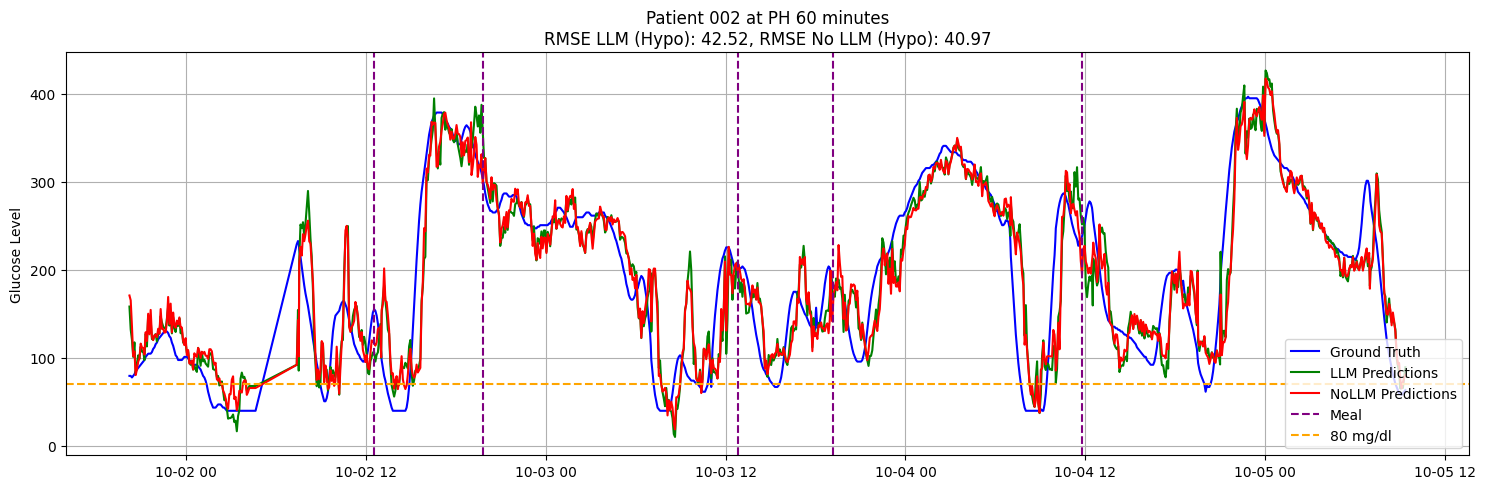

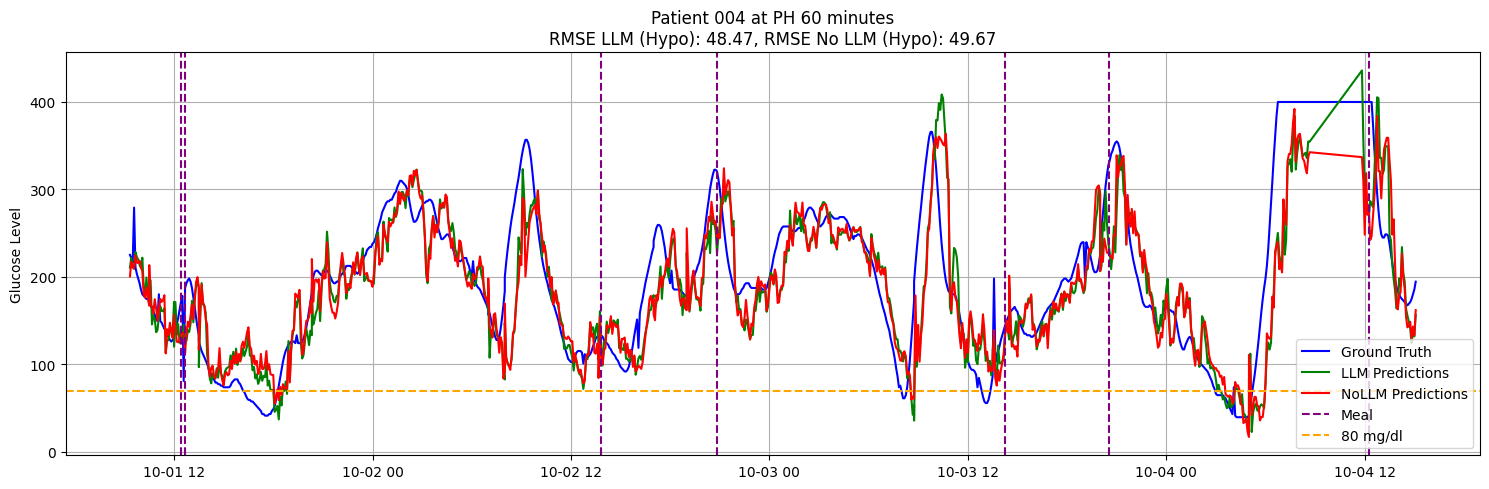

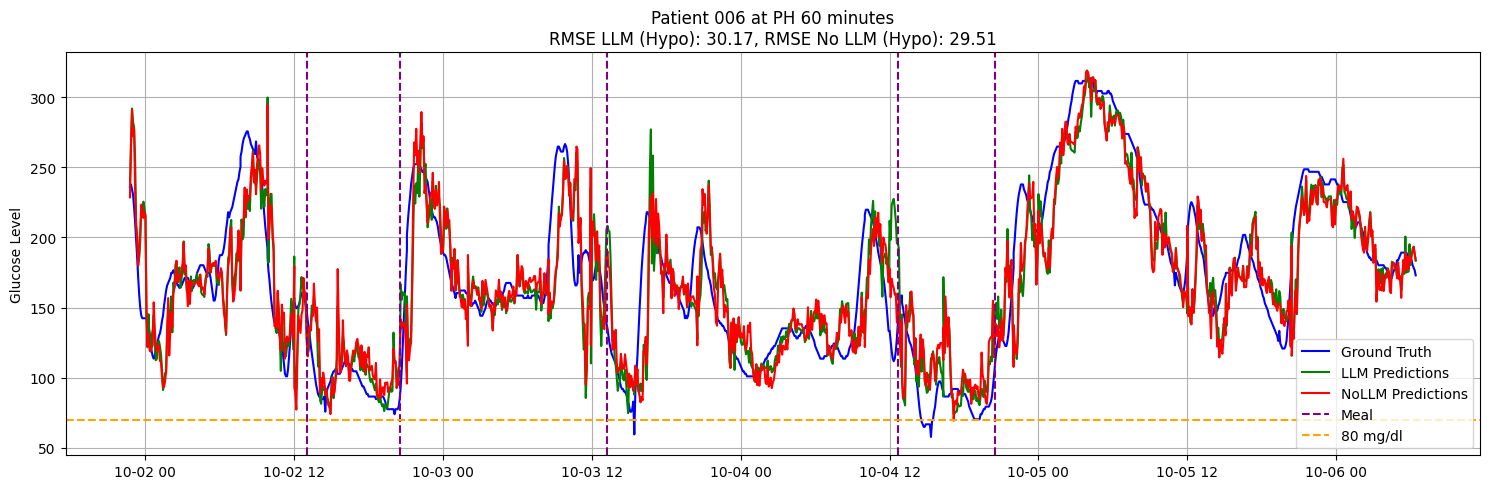

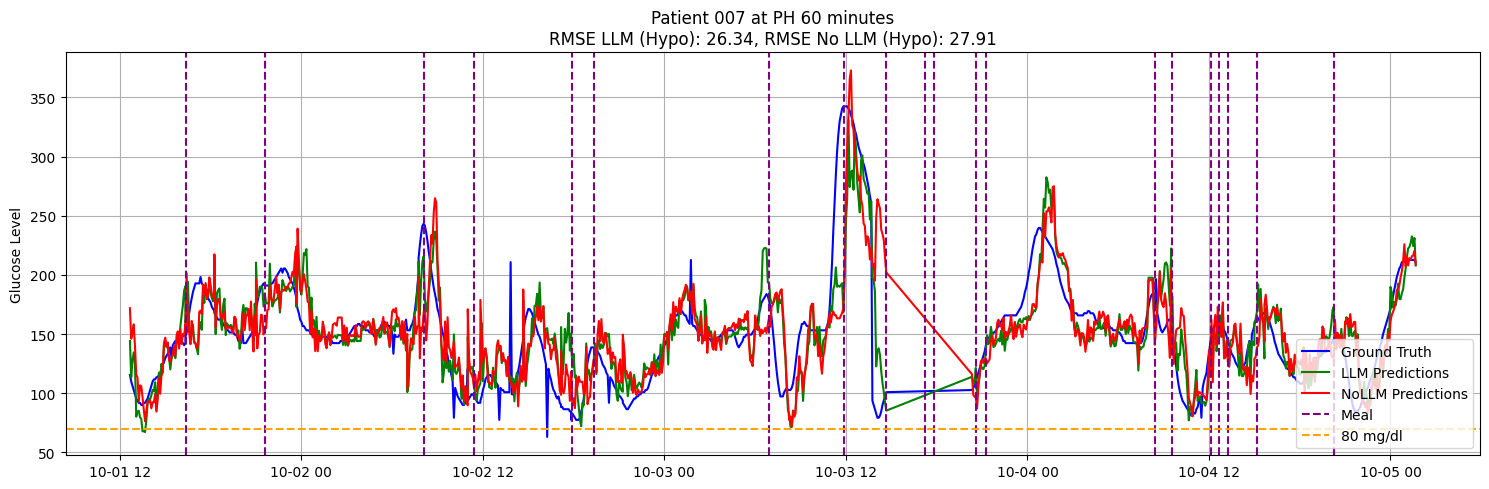

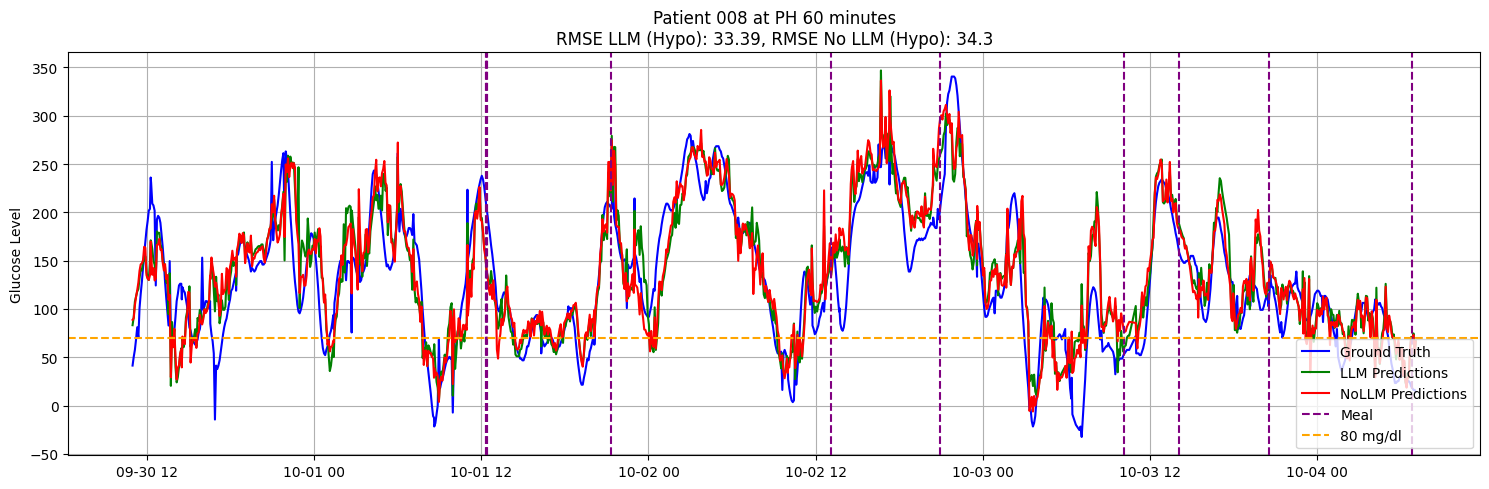

All plots have been saved as PNG files.


In [49]:
patients = ['001', '002', '004', '006', '007', '008']
prediction_horizon = 12
approaches = ['gpt4o', 'sonnet', 'llava', 'nollm']

for patient in patients:
    food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

    insulin_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
    insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')

    approach = 'nollm'
    nollm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")
    approach = 'gpt4o'
    llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")

    start_idx = 0
    end_idx = len(llm_preds)
    selected_idx = list(range(start_idx, end_idx))
    llm_preds = llm_preds.iloc[selected_idx, :]
    nollm_preds = nollm_preds.iloc[selected_idx, :]

    nollm_preds['Datetime'] = pd.to_datetime(nollm_preds['Datetime'])

    plt.figure(figsize=(15, 5))

    # Plot Ground Truth
    plt.plot(nollm_preds['Datetime'], nollm_preds['Initial_glucose'] - nollm_preds['Ground_truth'], label='Ground Truth', color='blue')

    # Plot Predictions
    plt.plot(nollm_preds['Datetime'], llm_preds['Initial_glucose'] - llm_preds['Predictions'], label='LLM Predictions', color='green')

    # Plot Predictions
    plt.plot(nollm_preds['Datetime'], llm_preds['Initial_glucose'] - nollm_preds['Predictions'], label='NoLLM Predictions', color='red')

    # Add vertical lines for meal times
    for idx, meal_time in food_data.iterrows():
        if nollm_preds['Datetime'].iloc[0] <= meal_time['datetime'] <= nollm_preds['Datetime'].iloc[-1]:
            plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

    # Add dummy plots to include in the legend
    plt.plot([], [], color='purple', linestyle='--', label='Meal')

    # Draw a line at 80 mg/dl
    plt.axhline(y=70, color='orange', linestyle='--', label='80 mg/dl')

    # Calculate RMSEs for hypoglycemic events only
    hypo_mask = nollm_preds['Ground_truth'] < 70
    rmse_no_llm = round(np.sqrt(mean_squared_error(nollm_preds.loc[hypo_mask, 'Ground_truth'], nollm_preds.loc[hypo_mask, 'Predictions'])), 2)
    rmse_llm = round(np.sqrt(mean_squared_error(llm_preds.loc[hypo_mask, 'Ground_truth'], llm_preds.loc[hypo_mask, 'Predictions'])), 2)

    plt.ylabel('Glucose Level')
    plt.legend(loc='lower right')
    plt.title(f'Patient {patient} at PH {prediction_horizon*5} minutes\nRMSE LLM (Hypo): {rmse_llm}, RMSE No LLM (Hypo): {rmse_no_llm}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Save the plot as a PNG file
    plt.savefig(f'patient_{patient}_predictions.png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free up memory

print("All plots have been saved as PNG files.")

## Investigate global feature importances

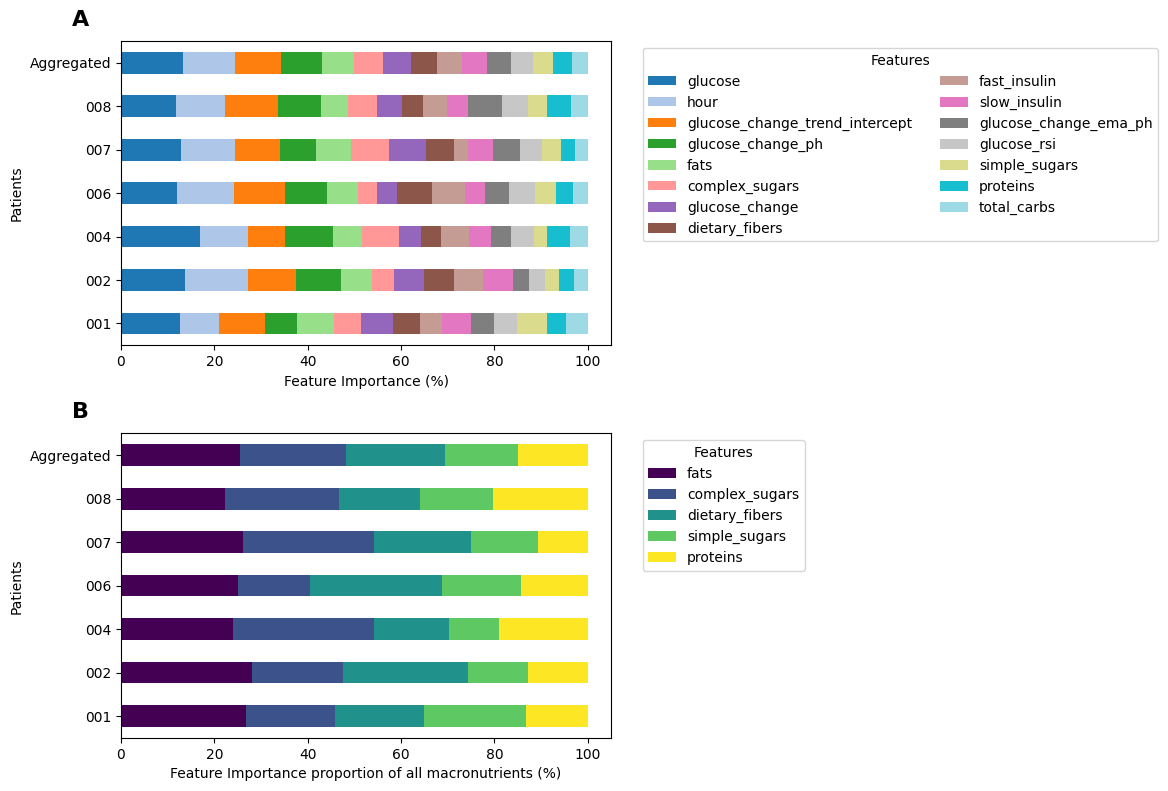

In [15]:
prediction_horizon = 6
model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importances_df['Aggregated'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='Aggregated', ascending=False)

# Prepare data for the second plot
combined_importances = pd.DataFrame()
features_of_interest = ['dietary_fibers', 'simple_sugars', 'fats', 'complex_sugars', 'proteins']

for feature in features_of_interest:
    combined_importances[feature] = importances_df.loc[feature]

combined_importances = combined_importances.transpose()
combined_importances['Aggregated'] = combined_importances.sum(axis=1)
combined_importances = combined_importances.sort_values(by='Aggregated', ascending=False)

normalized_importances = combined_importances.div(combined_importances.sum(axis=0), axis=1) * 100

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# First plot
importances_df.T.plot(kind='barh', stacked=True, colormap='tab20', ax=axes[0])
axes[0].set_xlabel('Feature Importance (%)')
axes[0].set_ylabel('Patients')
axes[0].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')

# Second plot
normalized_importances.T.plot(kind='barh', stacked=True, colormap='viridis', ax=axes[1])
axes[1].set_xlabel('Feature Importance proportion of all macronutrients (%)')
axes[1].set_ylabel('Patients')
axes[1].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
importances_df

,001,002,004,006,007,008,Aggregated
glucose,12.749350,13.803089,16.885339,12.025316,12.833169,11.755725,13.341998
hour,8.326106,13.320463,10.268112,12.236287,11.549852,10.636132,11.056159
glucose_change_trend_intercept,9.713790,10.328185,7.929264,10.812236,9.674235,11.195929,9.942273
glucose_change_ph,6.851691,9.652510,10.382202,9.018987,7.798618,9.312977,8.836164
fats,8.065915,6.756757,6.274957,6.645570,7.502468,5.699746,6.824235
complex_sugars,5.724198,4.729730,7.929264,4.061181,8.094768,6.259542,6.133114
glucose_change,6.851691,6.274131,4.563605,4.430380,7.897335,5.394402,5.901924
dietary_fibers,5.724198,6.467181,4.221335,7.489451,5.923001,4.427481,5.708775
fast_insulin,4.770165,6.177606,6.046777,6.962025,3.060217,5.089059,5.350975
slow_insulin,6.244579,6.467181,4.734740,4.377637,5.429418,4.631043,5.314100


In [18]:
importances_df.drop(['glucose', 'glucose_change_ph', 'slow_insulin', 'fast_insulin', 'glucose_change_ema_ph', 'glucose_rsi', 'glucose_change']).cumsum()

,001,002,004,006,007,008,Aggregated
hour,8.326106,13.320463,10.268112,12.236287,11.549852,10.636132,11.056159
glucose_change_trend_intercept,18.039896,23.648649,18.197376,23.048523,21.224087,21.832061,20.998432
fats,26.105811,30.405405,24.472333,29.694093,28.726555,27.531807,27.822667
complex_sugars,31.830009,35.135135,32.401597,33.755274,36.821323,33.791349,33.955781
dietary_fibers,37.554206,41.602317,36.622932,41.244726,42.744324,38.218830,39.664556
simple_sugars,44.145707,44.691120,39.418140,45.727848,46.890424,42.188295,43.843589
proteins,48.135299,47.779923,44.381061,49.525316,49.950642,47.379135,47.858563
total_carbs,52.818734,50.772201,48.146035,52.637131,52.615992,50.992366,51.330410


In [19]:
combined_importances

,001,002,004,006,007,008,Aggregated
fats,8.065915,6.756757,6.274957,6.645570,7.502468,5.699746,47.769647
complex_sugars,5.724198,4.729730,7.929264,4.061181,8.094768,6.259542,42.931797
dietary_fibers,5.724198,6.467181,4.221335,7.489451,5.923001,4.427481,39.961422
simple_sugars,6.591500,3.088803,2.795208,4.483122,4.146101,3.969466,29.253234
proteins,3.989592,3.088803,4.962921,3.797468,3.060217,5.190840,28.104815


In [20]:
normalized_importances

,001,002,004,006,007,008,Aggregated
fats,26.801153,28.0,23.965142,25.099602,26.116838,22.310757,25.406560
complex_sugars,19.020173,19.6,30.283224,15.338645,28.178694,24.501992,22.833522
dietary_fibers,19.020173,26.8,16.122004,28.286853,20.618557,17.330677,21.253711
simple_sugars,21.902017,12.8,10.675381,16.932271,14.432990,15.537849,15.558500
proteins,13.256484,12.8,18.954248,14.342629,10.652921,20.318725,14.947707


In [21]:
highest_macronutrient_per_column = normalized_importances.idxmax()  
highest_macronutrient_per_column  

001                     fats
002                     fats
004           complex_sugars
006           dietary_fibers
007           complex_sugars
008           complex_sugars
Aggregated              fats
dtype: object

## Change in feature importances over different prediction horizons

In [22]:
model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importance_sums = importances_df.sum(axis=1)
repeated_elements = [item for item in importance_sums.index for _ in range(3)]


ph_importances_df = pd.DataFrame({'PH': [6, 9, 12]*len(importance_sums), 'Feature': repeated_elements, 'Importance': 0.0, 'SD': 0.0})
for prediction_horizon in ['6', '9', '12']:
    model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df = pd.DataFrame(index=model.feature_name_)

    patients = ['001', '002', '004', '006', '007', '008']
    for patient in patients:
        model_path = f"models/gpt4o/{prediction_horizon}/lightgbm_model_{patient}.joblib"
        model = joblib.load(model_path)
        importances_df[patient] = model.feature_importances_

    # Normalize importances
    importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
    importance_means = importances_df.mean(axis=1)
    importance_stds = importances_df.std(axis=1)
    for feature in importance_means.index:
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'Importance'] = importance_means[feature]
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'SD'] = importance_stds[feature]

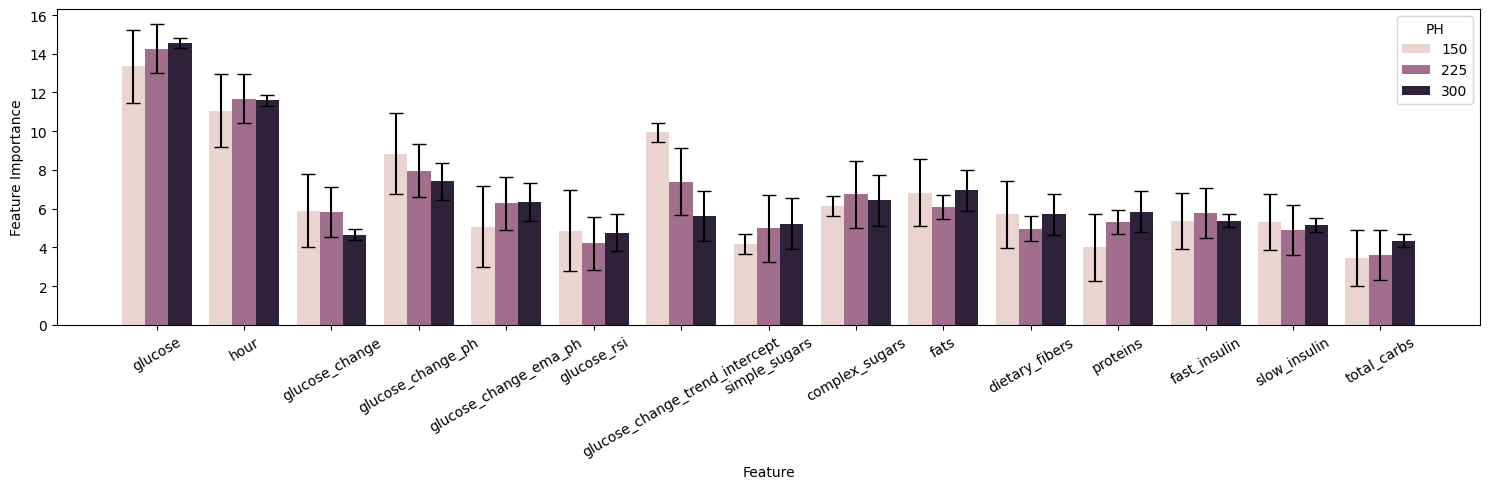

In [45]:
# Plotting the barplot with error bars
ph_importances_df['PH'] *= 5
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Feature', y='Importance', hue='PH', data=ph_importances_df)

# Add standard error bars
for i, bar in enumerate(ax.patches):
    # Get the center of each bar
    x = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()
    
    # Retrieve the corresponding standard deviation (SD) for the error bar
    std = ph_importances_df.iloc[i // 3]['SD']  
    
    # Add the error bar
    if height != 0:
        ax.errorbar(x=x, y=height, yerr=std, fmt='none', c='black', capsize=5)

plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(rotation=30)
plt.legend(title='PH')
plt.tight_layout()
plt.show()

In [24]:
highest_phs = []
for feature in ph_importances_df.Feature.unique():
    selected_df = ph_importances_df[ph_importances_df['Feature']==feature]
    highest_ph = selected_df.loc[selected_df['Importance']==selected_df['Importance'].max(), 'PH'].values[0]
    highest_phs.append(highest_ph)

feature_most_impact_ph_df = pd.DataFrame({'Feature': ph_importances_df.Feature.unique(), 'PH': highest_phs})

In [25]:
ph_importances_df

,PH,Feature,Importance,SD
0,30,glucose,13.341998,1.877654
1,45,glucose,14.262175,2.085992
2,60,glucose,14.553758,0.506070
3,30,hour,11.056159,1.732867
4,45,hour,11.684487,1.448120
5,60,hour,11.602463,1.271821
6,30,glucose_change,5.901924,1.359145
7,45,glucose_change,5.832089,1.727062
8,60,glucose_change,4.660499,0.633850
9,30,glucose_change_ph,8.836164,1.290896


In [26]:
for ph in [6, 9, 12]:
    features_at_ph = feature_most_impact_ph_df.loc[feature_most_impact_ph_df['PH']==ph, 'Feature'].values
    print(f'Features that have highest impact at PH {ph*5}: {features_at_ph}')

Features that have highest impact at PH 30: []
Features that have highest impact at PH 45: []
Features that have highest impact at PH 60: []


## Investigate local feature importances

Intercept 21.643286557499398
Prediction_local [-41.92326493]
Right: -102.99837649182105
Intercept -6.0272323189496655
Prediction_local [40.8863387]
Right: 93.18577571981113


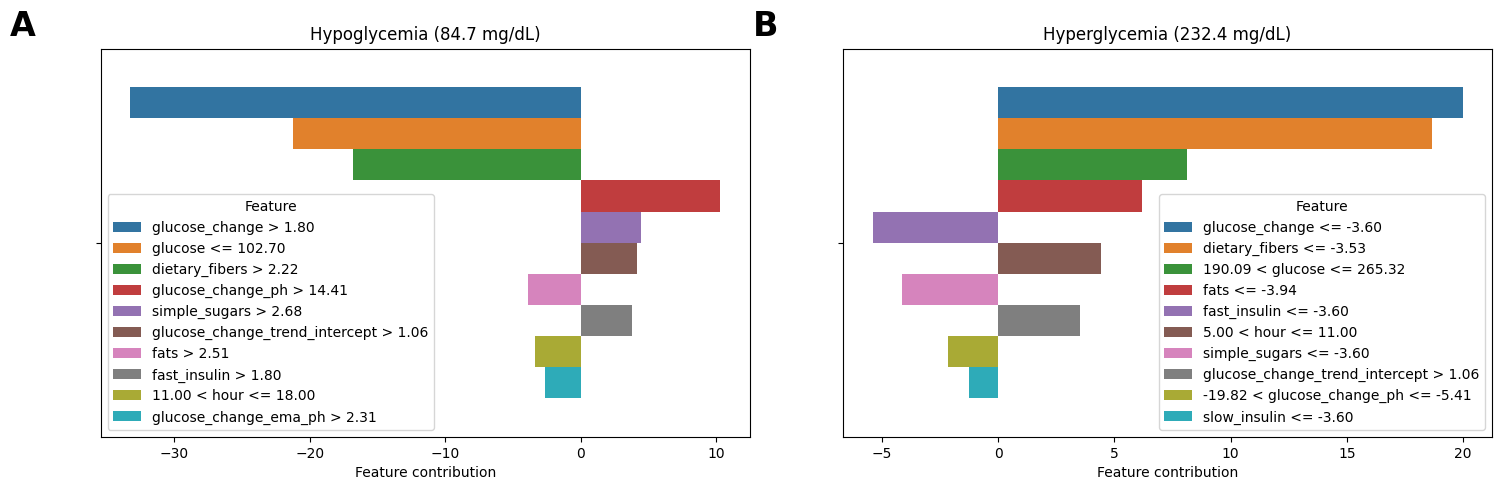

In [46]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '002'   
data = pd.read_csv(f"data/{approach}/{prediction_horizon}/data.csv")  
data = data[data['patient']==int(patient[2])]
X = data.drop(['glucose_next', 'datetime', 'patient'], axis=1)  
y = data['glucose_next']
model_path = f"models/{approach}/{prediction_horizon}/lightgbm_model_{patient}.joblib"  
model = joblib.load(model_path)  
explainer = LimeTabularExplainer(X.values,   
                                 feature_names=X.columns,   
                                 class_names=['glucose_next'],   
                                 verbose=True,   
                                 mode='regression')  
  
def predict_fn(data):  
    return model.predict(data)  
hypoglycemia_idx = np.argmin(data['glucose_next'])
hyperglycemia_idx = np.argmax(data['glucose_next'])


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, idx in enumerate([hypoglycemia_idx, hyperglycemia_idx]):
    instance = X.iloc[idx].values.reshape(1, -1)  
    exp = explainer.explain_instance(instance[0], predict_fn, num_features=len(X.columns))   
    feature_importances = exp.as_list()  
    importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    # Sort by absolute importance and take top 10
    importance_df['Abs_Importance'] = importance_df['Importance'].abs()
    importance_df = importance_df.nlargest(10, 'Abs_Importance').drop('Abs_Importance', axis=1)
    sns.barplot(x='Importance', hue='Feature', data=importance_df, ax=axs[i])  
    axs[i].text(-0.1, 1.1, f"{chr(65+i)}", transform=axs[i].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
    axs[i].set_title(f'{"Hypoglycemia" if i == 0 else "Hyperglycemia"} ({round(data.iloc[idx, 0], 1)} mg/dL)')
    axs[i].set_xlabel('Feature contribution')

plt.tight_layout()  
plt.show()  

## Visualize feature mapping over time 

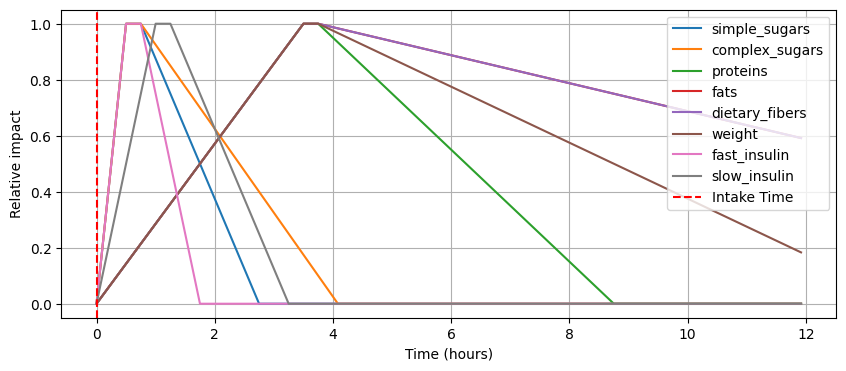

In [28]:
feature_params = {
    'simple_sugars': [0.5, 0.5],          # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.05, 3.5],
    'weight': [0.1, 3.5], 
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

times = np.arange(0, 12, (1/12))
intake_time = 0

glucose_data = pd.DataFrame({'Time': times})

for feature, param in feature_params.items():
    time_diff_hours = times - intake_time
    metabolism_rate, peak_time = param[0], param[1]
    plateau_duration = 0.25
    
    weights = np.zeros_like(time_diff_hours)

    # Linear increase (before the peak)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time

    # Plateau (at the peak)
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1

    # Linear decrease (after the plateau)
    decrease_mask = (time_diff_hours >= peak_time + plateau_duration)
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration))*metabolism_rate
    weights = np.clip(weights, 0, np.inf) 
    glucose_data[feature] = weights

plt.figure(figsize=(10, 4))
for feature in feature_params.keys():
    plt.plot(glucose_data['Time'], glucose_data[feature], linestyle='-', label=feature)

plt.axvline(x=intake_time, color='r', linestyle='--', label='Intake Time')

plt.xlabel('Time (hours)')
plt.ylabel('Relative impact')
plt.legend()
plt.grid(True)
plt.show()

## Differences in macronutrient estimation between LLMs

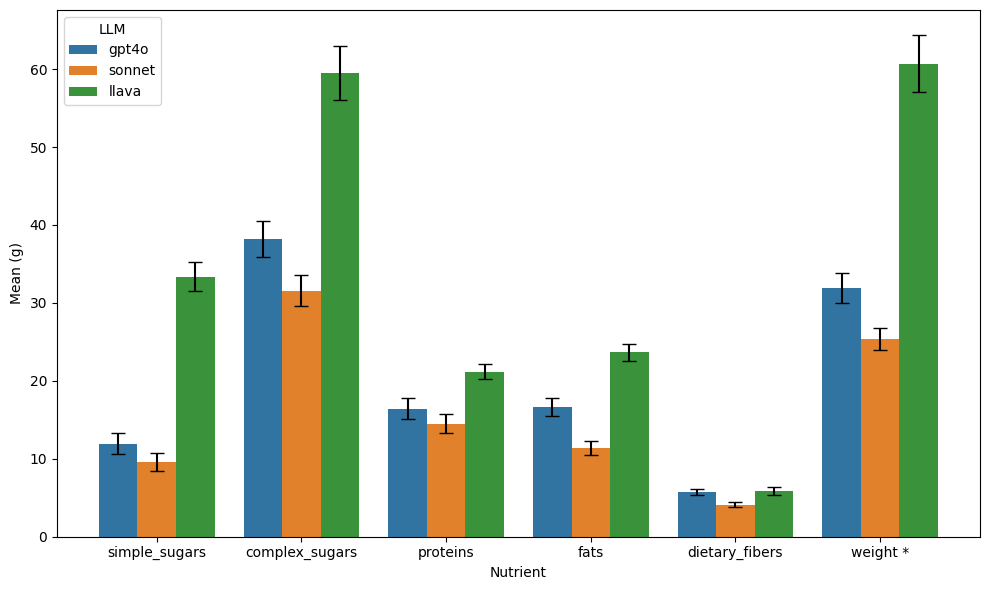

In [29]:
approaches = ['gpt4o', 'sonnet', 'llava']

data = {approach: [] for approach in approaches}

# Load the data
for approach in approaches:
    for patient in patients:
        food_data = pd.read_csv(f'food_data/{approach}/{patient}.csv')
        data[approach].append(food_data)

# Compute the mean and standard error for each approach
results = {'Approach': [], 'Nutrient': [], 'Mean': [], 'Std Error': []}
nutrients = ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers', 'weight *']

for approach, dfs in data.items():
    combined_df = pd.concat(dfs)
    combined_df['weight *'] = combined_df['weight'] / 10
    for nutrient in nutrients:
        mean_value = combined_df[nutrient].mean()
        std_error = combined_df[nutrient].sem()
        results['Approach'].append(approach)
        results['Nutrient'].append(nutrient)
        results['Mean'].append(mean_value)
        results['Std Error'].append(std_error)

results_df = pd.DataFrame(results)

# Plotting the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Nutrient', y='Mean', hue='Approach', data=results_df, errorbar=None, capsize=0.1)

# Add standard error bars
num_approaches = len(approaches)
bar_width = 0.8 / num_approaches 
for i, approach in enumerate(approaches):
    approach_data = results_df[results_df['Approach'] == approach]
    x_positions = np.arange(len(nutrients)) - 0.4 + bar_width/2 + i * bar_width
    plt.errorbar(x=x_positions, y=approach_data['Mean'], yerr=approach_data['Std Error'], fmt='none', c='black', capsize=5)

plt.xlabel('Nutrient')
plt.ylabel('Mean (g)')
plt.legend(title='LLM')
plt.tight_layout()
plt.show()

## Determine performance when forecasting hypo- and hyperglycemia

In [61]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '004'
preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")

In [62]:
# Calculate glucose at prediction horizon by adding ground truth to initial glucose
preds['Glucose_at_PH'] = preds['Initial_glucose'] - preds['Ground_truth']
preds['Predicted_Glucose_at_PH'] = preds['Initial_glucose'] - preds['Predictions']

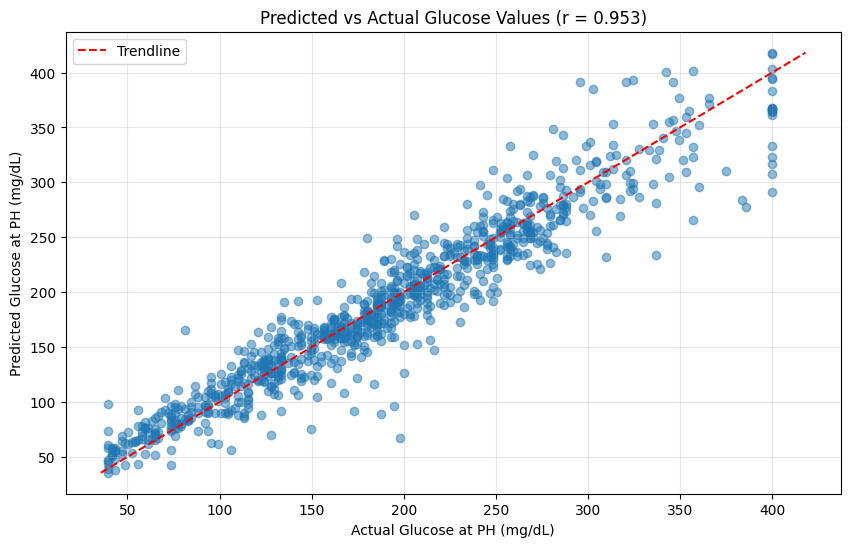

In [69]:
# Calculate correlation coefficient
corr_coef = preds['Glucose_at_PH'].corr(preds['Predicted_Glucose_at_PH'])

plt.figure(figsize=(10, 6))
plt.scatter(preds['Glucose_at_PH'], preds['Predicted_Glucose_at_PH'], alpha=0.5)
plt.xlabel('Actual Glucose at PH (mg/dL)')
plt.ylabel('Predicted Glucose at PH (mg/dL)')
plt.title(f'Predicted vs Actual Glucose Values (r = {corr_coef:.3f})')

# Add diagonal line representing perfect predictions
min_val = min(preds['Glucose_at_PH'].min(), preds['Predicted_Glucose_at_PH'].min())
max_val = max(preds['Glucose_at_PH'].max(), preds['Predicted_Glucose_at_PH'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Trendline')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()